# Implementation of the vectorized Forward-Backward algorithm #

This notebook presents a vectorized implementation of the Forward-Backward algorithm for sequence alignments. The theoretical notation utilized is derived from the Mückstein paper titled "Stochastic pairwise alignments" (DOI: https://doi.org/10.1093/bioinformatics/18.suppl_2.S153). Equation 7 of the paper introduces the algorithm and is shown here
$$
  Z_{i,j}^M = (Z_{i-1,j-1}^M + Z_{i-1,j-1}^E +Z_{i-1,j-1}^F) e^{ \beta s(a_i, b_i)}
$$
$$
  Z_{i,j}^E = Z_{i,j-1}^M e^{\beta g_o} + Z_{i,j-1}^E e^{\beta g_{ext}}
$$
$$
  Z_{i,j}^F = Z_{i-1,j}^M e^{\beta g_o} + Z_{i-1,j}^F e^{\beta g_{ext}}
$$
In this context, where $ \beta $ represents a temperature constant, $ g_o $ and $ g_{ext} $ denote the gap opening and gap extension penalties respectively, and $ s(a_i, b_j) $ represents the substitution matrix.\
The algorithm requires a rewriting of the calculation rule for the $ Z^E $ matrix to achieve vectorization.

$$
Z_{i,j}^E = Z_{i,j-1}^M e^{\beta g_o} + (Z_{i,j-2}^M e^{\beta g_o} + Z_{i,j-2}^E e^{\beta g_{ext}}) e^{\beta g_{ext}}\\
$$
When we do this more often we get this result for the last element of our $Z_{i,[1,...,L_1]}^E$ vector. 

$$
Z_{i,L_1}^E = e^{\beta g_o} (Z_{i,L-1}^M + Z_{i,L-2}^M e^{\beta g_{ext}} + ... + Z_{i,2}^M e^{\beta (L_1-2)g_{ext}}+ Z_{i,1}^M e^{\beta (L_1-1)g_{ext}}) + Z_{i,1}^E e^{\beta (L_1-1)g_{ext}}
$$

(Note that the $Z_{i,1}^E$ entry is initialized with zero for global alignments, and the global the multiplication factor changes for each entry)

When we look at this more closely we see, that we can use this to calculate the $Z^E$ matrix at all positions by taking the cumulative sum and then rescaling the result for every entry by dividing by gap penalties that we added to often.\
This can be done in three Steps.\
First define two vectors $v$ and $w$ in this way:

$$
V_j = e^{(g_o + (L_1 - j) g_{ext})\beta}\\
$$
$$
W_j = e^{((L_1 - j) g_{ext})\beta}\\ 
$$
$$
\text{for}   j = 1,...,L_1
$$

The second step is calculating the cumulative sum over $Z_{i, [1,...,L_1]}^M$ Multiplied by elementwise with the $v_j$ vector

$$
Z_{i,[1,...,L_1]}^E = CumSum(Z_{i, [1,...,L_1]}^M  V_{[1,...,L_1]})
$$
Now we have the correct result only in the last element of our $Z_{i,[1,...,L_1]}^E$ vector. The other elements are penalties too often.\
This can be fixed by rescaling the results in the third step by dividing elementwise with the $W_j$ vector

$$
Z_{i,[1,...,L_1]}^E = \frac{Z_{i,[1,...,L_1]}^E}{W_{[1,...,L_1]}}
$$
How we can vectorize the cumulative sum is described in this [blockposed](https://en.algorithmica.org/hpc/algorithms/prefix/).

The final probability matrix is then calculated using equation 11 in the Mückstein paper. 

$$
P_{ij} = \frac{Z_{ij}^M \hat{Z}_{ij}^M}{Z} e^{-\beta s(a_i,b_j)}
$$
where $\hat{Z}^M$ is the result from the backward algorithm 

The normalization constant $Z$ needs to be chosen differently depending on the local or global algorithm. For the global algorithm, we divide by $Z = Z_{L_1, L_2}^M + Z_{L_1, L_2}^E + Z_{L_1, L_2}^F$.
For the local alignment, we need to divide by the sum of the $Z^M$ matrix plus one for the empty alignment 
($Z = 1 + \sum_{ij}Z_{ij}^M$.)

There are two more differences between local and global alignments. The first is the calculation of the $Z^M$ matrix. For the global alignments, we have to use the formula described above for the local alignment we have to add one at each position: 
$$
Z_{i,j}^M = (Z_{i-1,j-1}^M + Z_{i-1,j-1}^E +Z_{i-1,j-1}^F + 1) e^{ \beta s(a_i, b_i)}\\
$$

The second difference is the initialization of the $Z^M, Z^E, Z^F$ matrix. For the local version, we can initialize all three with zero. For the global alignment, we have to initialize the first row of the $Z^E$ and the first colum of the $Z^F$ matrix.

$$
Z_{0, [1,...,L_1]}^E = e^{(g_o + i * g_{ext})\beta}; i = 0,...,L_1 - 1\\
Z_{[1,...,L_2], 0}^F = e^{(g_o + j * g_{ext})\beta}; j = 0,...,L_2 - 1\\
Z_{0,0}^M = 1\\
$$

The whole algorithm comes with some numerical problems since we work in the exponential space we see over- and underflow problems quickly. In this notebook, we introduce some tricks to make the algorithm more stable.


In [42]:
import numpy as np
import matplotlib.pyplot as plt
import os.path
from scipy.spatial.distance import cdist
import time
from tqdm import tqdm
from scipy.special import logsumexp
import numba

%load_ext autoreload
%autoreload 1
#%aimport __pycache__.lddt.cpython-39
%aimport sautils.encoder_commons
%aimport sautils.common
%aimport torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
# This Cell is just for loading the Data and Substitution matix. In our case we use the mat3di and blosum62 matrix
# in the way it is used in the foldseek paper.

sid2seq_ss = {}
with open('data/ss.fasta') as file:
    sid = ''
    for line in file:
        line = line.lstrip('>').rstrip('\n')
        if not sid:
            sid = line
        else:
            sid2seq_ss[sid] = line
            sid = ''
sid2seq_aa = {}
with open('data/aa.fasta') as file:
    sid = ''
    for line in file:
        line = line.lstrip('>').rstrip('\n')
        if not sid:
            sid = line
        else:
            sid2seq_aa[sid] = line
            sid = ''
mat3di = np.load('data/mat3di.npy') * 2.1
blosum = np.load('data/blosum62.npy') * 1.4
with open('data/mat3di.out') as f:
    lines = f.readlines()
i2a = lines[3].split()
def seq2num(q):
    idx = []
    for a in q:
        idx.append(i2a.index(a))
    return np.array(idx)
    
def calcS_np(ss1,ss2 ,aa1, aa2,mat3di, blosum):
    ss1 = seq2num(ss1)
    ss2 = seq2num(ss2)
    aa1 = seq2num(aa1)
    aa2 = seq2num(aa2)
    comb_array_ss = np.array(np.meshgrid(ss1, ss2)).T.reshape(-1, 2)
    comb_array_aa = np.array(np.meshgrid(aa1, aa2)).T.reshape(-1, 2)
    S = (mat3di[comb_array_ss[:,0],comb_array_ss[:,1]].reshape(len(ss1),-1)) + blosum[comb_array_aa[:,0],comb_array_aa[:,1]].reshape(len(aa1),-1)
    return S


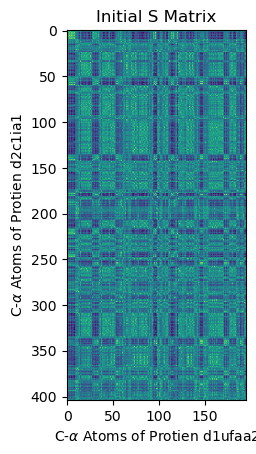

In [44]:
# This Cell prepares the S Matrix we use to calculate the forward backward algorithm.

#query = 'd1dkza1'
#target = 'd2p06a1'
#query, target = "d1bm9a_", "d1ku9a_"
query, target = "d1ufaa2", "d2c1ia1"
query, target = "d1ec7a1","d1hjua_"
#query, target = "d1hyua4", "d1gz0a2"
query = "d1ufaa2"
target = "d2c1ia1"


aa1 = sid2seq_aa[query]
aa2 = sid2seq_aa[target]
ss1 = sid2seq_ss[query]
ss2 = sid2seq_ss[target]
S = calcS_np(ss1, ss2, aa1, aa2, mat3di, blosum)
im = plt.imshow(S)
plt.xlabel(r'C-$\alpha$ Atoms of Protien '+ query)
plt.ylabel(r'C-$\alpha$ Atoms of Protien '+ target)
plt.title("Initial S Matrix")
plt.show()


In [45]:
S

array([[  7.     ,   0.7    ,  -7.7    , ...,  -9.8    ,  -7.7    ,
          7.     ],
       [  1.0724 ,  12.33484,   3.93484, ..., -16.6789 , -15.05476,
          0.89054],
       [ -3.34782,   0.69636,  15.39636, ..., -13.3371 , -29.54812,
         -6.46156],
       ...,
       [  1.0906 ,  -6.4645 , -16.9645 , ...,  -4.54986,  -1.56646,
          1.93522],
       [  5.05218,  -5.60364, -16.10364, ...,   3.4629 ,  -2.24812,
          1.93844],
       [  5.23264,   7.37646,  -1.02354, ..., -11.90364, -10.69964,
          4.98078]])

In [46]:
def plot_matrices(P, zm, zm_hat):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.imshow(P)
    ax1.set_title("P")
    ax2.imshow(zm)
    ax2.set_title("Forward")
    ax3.imshow(zm_hat)
    ax3.set_title("Backward")
    #plt.tight_layout()

### Plain algorithm without numerical tricks ###

In this section, we implement the first algorithm which does not catch any numerical overflows or underflows. As described in the Muckstein paper the implementation difference between the local and global alignment is not big. To make it kind of stable we used np.longdouble. What numpy uses then depends on the system it is running (https://numpy.org/doc/stable/reference/arrays.scalars.html#numpy.longdouble, In our case it was: https://en.wikipedia.org/wiki/Extended_precision#x86_extended_precision_format). 

In [47]:
def forward_backward_plain_local(S, vj, wj, T, go, ge, pre):
    #create all matrix we need
    exp_go = np.exp(go/T)
    exp_ge = np.exp(ge/T)
    zm = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    ze = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    zf = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    
    #This is the main part where we calculate the Z matrices with one for loop over each row
    for i in range(1,S.shape[0]+1):
        zm[i,1:] = ((zm[i-1,:-1] + ze[i-1,:-1] + zf[i-1,:-1] + 1) *S[i-1,:])
        # this is the new part where ze is calculated using cumsum 
        #ze[i,1:] = (np.cumsum(zm[i,:-1] * vj)/wj)
        for j in range(1,S.shape[1]+1):
            ze[i,j] = zm[i,j-1]*exp_go + zm[i,j-1] *exp_ge
        zf[i,1:] = (zm[i-1,1:] * exp_go + zf[i-1,1:] * exp_ge)
    #at the end we only need to return zm but for testing i returned all
    return zm, ze, zf

def forward_backward_plain_global(S, vj, wj, T, go, ge, pre):
    exp_go = np.exp(go/T)
    exp_ge = np.exp(ge/T)
    zm = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    ze = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    zf = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    
    zm[0,0], ze[0,0], zf[0,0] = 1,0,0
    #zf[1:,0] = np.exp(np.linspace(go,go+(ge*(S.shape[0]-1)), S.shape[0])/T)
    ze[0,1:] = np.exp(np.linspace(go,go+(ge*(S.shape[1]-1)),S.shape[1])/T)
    # as described at the beginning we can't calculate the ze matrix only using the zm matrix but for each entry
    # we have one final ze value from the initialization which stays in each line.
    # This needs to be added in each turn with a different scale. Here we prepare the scale vector
    exp_ge_arr = np.exp((np.arange(ge, (S.shape[1] + 1)* ge ,ge,dtype = pre))/T)
                        
    #This is the main part where we calculate the Z matrices with one for loop over each row
    for i in range(1,S.shape[0]+1):
        zm[i,1:] = (zm[i-1, :-1] + ze[i-1,:-1] + zf[i-1,:-1]) * S[i-1,:]
        ze[i,1:] = (np.cumsum(zm[i,:-1] * vj)/wj) #+  * exp_ge_arr
        zf[i,:] = zm[i-1,:] * exp_go + zf[i-1,:] * exp_ge
    return zm, ze, zf
    
    

In [6]:
T = 10
go = -3.5
ge = -.3
local = True
pre = np.float64

CPU times: user 45.8 ms, sys: 3.95 ms, total: 49.8 ms
Wall time: 49.3 ms


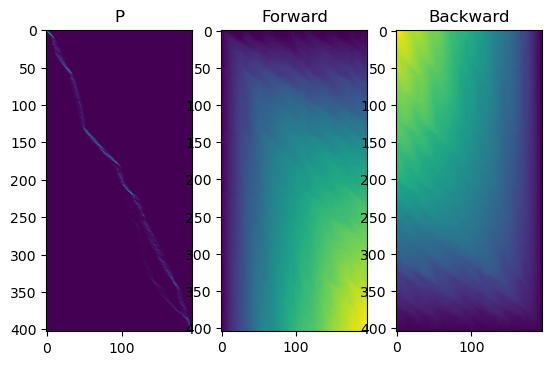

In [7]:
%%time
# T = tempreture parameter, go = gap opening pe


# In our case the S matrix is in the Logspace. So we have to calculate the exponent of the S matrix. 
S_exp = np.exp(S/T, dtype = pre)
# *_hat describes the results of the backward algorithm inspired from the muckstein paper. 
#Since the Backward algorithm is the same as the forward just with the flipped input matrix we flip our S matrix here.
S_hat = S_exp[::-1,::-1]

# prepare the V and W vectors as described.
vj = np.exp(np.arange((S.shape[1]-1)*ge + go ,go-ge, -ge, dtype = pre)/T)
wj = np.exp((np.arange((S.shape[1]-1)*ge , -ge, -ge, dtype = pre)) /T)
#print(np.arange((S.shape[1]-1)*ge + go ,go-ge, -ge, dtype = pre))

# check if we want to calculate a local alignment
if local == True:
    #calculate the forward and backward path. 
    zm, ze, zf = forward_backward_plain_local(S_exp, vj, wj, T, go, ge, pre)
    zm_hat, ze_hat, zf_hat = forward_backward_plain_local(S_hat, vj, wj, T, go, ge, pre)
    # To calculate the final probability matrix we have to multiply zm and zm_hat pairwise and normalize it by 
    # the sum over zm as described in the muckstein paper
    # not that with [1:,1:] we skip the initialization part we have to flip the backward path back. 
    P = ((zm[1:,1:]*(zm_hat[::-1,::-1])[:-1,:-1])/(1 + np.sum(zm))) * np.exp(-S/T)

#the global alignment 
else:
    #calculate the forward and backward path. 
    zm, ze, zf = forward_backward_plain_global(S_exp, vj, wj, T, go, ge, pre)
    zm_hat, ze_hat, zf_hat = forward_backward_plain_global(S_hat, vj, wj, T, go, ge, pre)
    # Here we only have to normalize by the last element of our zm matrix
    P = (zm[1:,1:]*(zm_hat[::-1,::-1])[:-1,:-1])/ (zm[-1,-1]+ze[-1,-1] +zf[-1,-1]) * np.exp(-S/T)  

# plot the final alignment
plot_matrices(P[1:,1:], np.log(zm[1:,1:]), np.log(zm_hat[1:,1:][::-1,::-1]))

In [8]:
np.save("/home/lasse/Desktop/Prosa/P_test.npy", P)

/tmp/ipykernel_99062/3519847854.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(zm_hat))


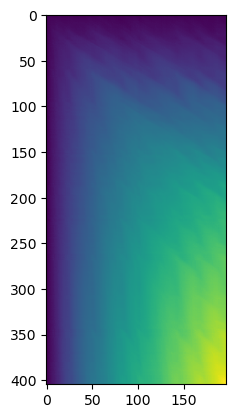

In [9]:
plt.imshow(np.log(zm_hat))

/tmp/ipykernel_99062/3698013959.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(zm))


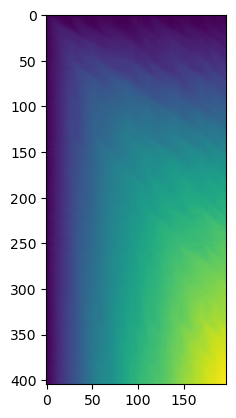

In [10]:
plt.imshow(np.log(zm))

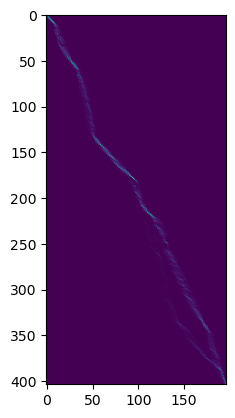

In [11]:
# plot the logarithm of the backward path
plt.imshow(P)

### Save the maximum ###
The initial observation reveals that values in $Z$ matrices grow rapidly in size. To mitigate this, each line can be rescaled by its maximum value. This approach, as demonstrated in this section, resolves the overflow issue. However, it introduces a new challenge: the values diminish too quickly, causing the algorithm to fail.



In [12]:
def forward_backward_saveMax_local(S, vj, wj, T, go, ge, pre):
    exp_go = np.exp(go/T)
    exp_ge = np.exp(ge/T)
    zm = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    ze = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    zf = np.zeros((S.shape[0]+2, S.shape[1]+1), dtype = pre)
    
    zmax = np.zeros(S.shape[0]+1)
    current_max = 0
    
    for i in range(1,S.shape[0]+1):
        #we have to rescale the +1 in the formula by the sum of all the max
        zm[i,1:] = ((zm[i-1,:-1] + ze[i-1,:-1] + zf[i-1,:-1] + (np.exp(-current_max))) *S[i-1,:])
        ze[i,1:] = (np.cumsum(zm[i,:-1] * vj)/wj) 
        zf[i,1:] = (zm[i-1,1:] * exp_go + zf[i-1,1:] * exp_ge)
        
        z_temp = np.max([zm[i,:],ze[i,:], zf[i,:]])
        # Only save the log of the maximum that we don't get overflow
        zmax[i] = np.log(z_temp)
        # also save the sum. I guess we could only save the cumsum of the maximum 
        current_max += zmax[i]
        # rescale all z by the maximum
        zm[i,:],ze[i,:], zf[i,:] = zm[i,:]/z_temp ,ze[i,:]/z_temp, zf[i,:]/z_temp
    return zm, ze, zf, zmax, current_max

def forward_backward_saveMax_global(S, vj, wj, T, go, ge, pre):
    exp_go = np.exp(go/T)
    exp_ge = np.exp(ge/T)
    zm = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    ze = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    zf = np.zeros((S.shape[0]+2, S.shape[1]+1), dtype = pre)
    
    zm[0,0], ze[0,0], zf[0,0] = 1,0,0
    #zf[1:,0] = np.exp(np.linspace(go, go+(ge* (S.shape[0])), S.shape[0])/T)
    #zf[1,0] = exp_go
    zf[1:-1,0] = np.exp(np.linspace(go,go+(ge*(S.shape[0]-1)), S.shape[0])/T)
    ze[0,1:] = np.exp(np.linspace(go,go+(ge*(S.shape[1]-1)),S.shape[1])/T)
    
    exp_ge_arr = np.exp((np.arange(ge, S.shape[1]* ge + ge,ge,dtype = pre))/T)
    
    zmax = np.zeros(S.shape[0]+1)
    current_max = 0
    
    for i in range(1,S.shape[0]+1):
        zm[i,1:] = (zm[i-1,:-1] + ze[i-1,:-1] + zf[i-1,:-1]) *S[i-1,:]
        ze[i,1:] = (np.cumsum(zm[i,:-1] * vj)/wj) + (ze[i,0] * exp_ge_arr)
        zf[i,:] = zm[i-1,:] * exp_go + zf[i-1,:] * exp_ge
        
        z_temp = np.max([zm[i,:],ze[i,:], zf[i,:]])
        #print(z_temp)
        zmax[i] = np.log(z_temp)
        current_max += zmax[i]
        zm[i,:],ze[i,:], zf[i,:] = zm[i,:]/z_temp ,ze[i,:]/z_temp, zf[i,:]/z_temp
        #zf[i+1,0] = np.exp(go + (i-1)*ge - current_max)
        
    return zm, ze, zf[:-1,:], zmax, current_max

/tmp/ipykernel_99062/2495400250.py:21: RuntimeWarning: divide by zero encountered in log
  zm, zm_hat = np.log(zm[1:,1:], dtype = pre), np.log(zm_hat[1:,1:], dtype = pre)


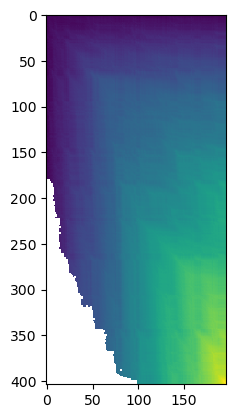

In [13]:
# T = tempreture parameter, go = gap opening pe
T = 1
go = -3.5
ge = -.3
local = True
#chose the datatype we want to use 
pre = np.float64
S_exp = np.exp(S/T, dtype = pre)
S_hat = S_exp[::-1,::-1]


# prepare the V and W vector as described.
vj = np.exp(np.arange((S.shape[1]-1)*ge + go ,go-ge, -ge, dtype = pre)/T)
wj = np.exp(np.arange((S.shape[1]-1)*ge , -ge, -ge, dtype = pre)/T)


# check if we want to calculate a local alignment
if local == True: 
    zm, ze, zf, zmax, current_max = forward_backward_saveMax_local(S_exp, vj, wj, T, go, ge, pre)
    zm_hat, ze_hat, zf_hat, zmax_hat, current_max_hat = forward_backward_saveMax_local(S_hat, vj, wj, T, go, ge, pre)
    zm, zm_hat = np.log(zm[1:,1:], dtype = pre), np.log(zm_hat[1:,1:], dtype = pre)
    zm = zm + np.cumsum(zmax[1:]).reshape(-1,1)
    zm_hat = zm_hat + np.cumsum(zmax_hat[1:]).reshape(-1,1)
    
    P = np.exp((zm + zm_hat[::-1,::-1] - (S/T) - logsumexp(zm)))


else:
    #calculate the forward and backward path. 
    zm, ze, zf, zmax, current_max = forward_backward_saveMax_global(S_exp, vj, wj, T, go, ge, pre)
    zm_hat, ze_hat, zf_hat, zmax_hat, current_max_hat = forward_backward_saveMax_global(S_hat, vj, wj, T, go, ge, pre)
    zm, zm_hat = np.log(zm[1:,1:]), np.log(zm_hat[1:,1:])
    zm = zm + np.cumsum(zmax[1:]).reshape(-1,1)
    
    ze[-1,-1] = np.log(ze[-1,-1]) + current_max
    zf[-1,-1] = np.log(zf[-1,-1]) + current_max
    zm_hat = zm_hat + np.cumsum(zmax_hat[1:]).reshape(-1,1)

    
    P = np.exp(zm + zm_hat[::-1,::-1] - logsumexp([zm[-1,-1], ze[-1,-1], zf[-1,-1]])  - (S/T))

plt.imshow(zm_hat)

Here we will try to visualize the problem of the underflowing.
We start with a local alignment and $g_o = 0.3, g_{ext} = 3.5, T = 10$ and float64 values. With this settings everything works fine:
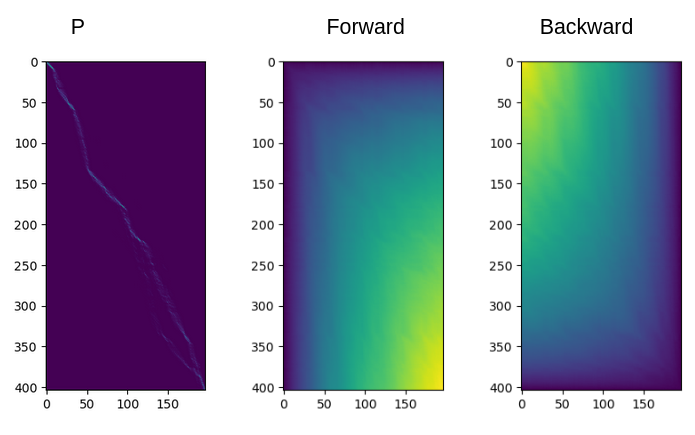

When we reduce our precision to float32 we see, that the alignment matrix P locks still correct. But in the forward and backward matrix we see that some values are 0 which leads to negative infinity in logspace.
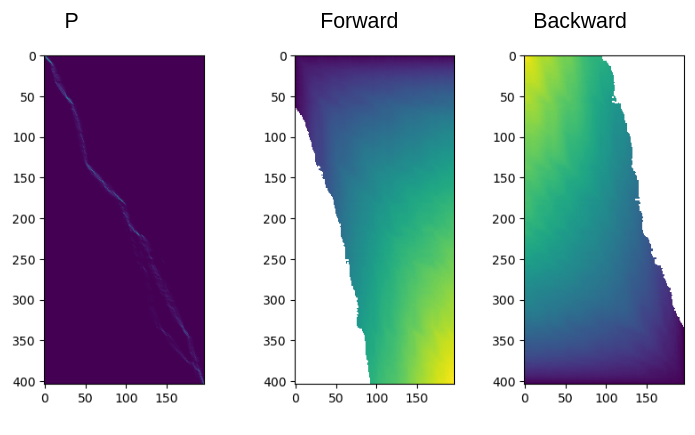

When we work in with float32 and reduce the tempreture to 2 we see that our algorithm fails.
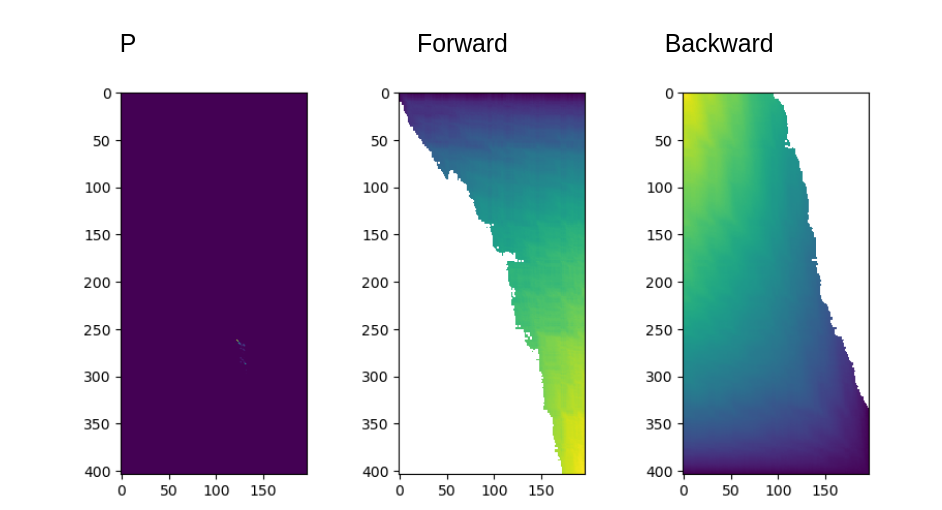

### Underflowing of W and V ###
In this Section we will not focus on fixing the general underflowing problem but on the specific underflowing of the V and W vector.
$
V_j = e^{(g_o + (L_1 - j) g_{ext})\beta}\\
W_j = e^{(L_1 - j) g_{ext}\beta}\\
$
We observe that these arrays quickly approach zero. For instance, if we set $g_{o} = -5$, $g_{ext} = -1$, and $\beta = 1$, these vectors would reach 0 within a sequence length exceeding 50 (using float32). However, in our algorithm, this would result in calculating $\frac{0}{0}$, leading to NaN and causing the algorithm to fail.

To tackle this issue, we'll break down each line into fixed-length blocks to prevent underflow in these matrices. The block length will be determined at the beginning of the algorithm and chosen as a power of 2. With AVX2, we can select the block length to match the number of floats that fit in the AVX2 register, as we already perform blockwise CumSum calculations.

In [51]:
def forward_backward_block_local(S, vj, wj, T, go, ge, length, pre):
    exp_go = np.exp(go/T)
    exp_ge = np.exp(ge/T)
    zm = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    ze = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    zf = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    
    zmax = np.zeros(S.shape[0]+1)
    
    current_max = 0
    
    blocks = int(S.shape[1]/length)
    start, end = 0,0
    rest = S.shape[1] - (blocks*length)
    exp_ge_arr = np.exp((np.arange(ge, length* ge + ge,ge,dtype = pre))/T)
    
    
    for i in range(1,S.shape[0]+1):
        zm[i,1:] = ((zm[i-1,:-1] + ze[i-1,:-1] + zf[i-1,:-1] + np.exp(-current_max)) *S[i-1,:])
        for b in range(blocks):
            start, end = b*length, (b+1) * length
            ze[i, start+1: end+1] = (np.cumsum(zm[i,start: end] * vj)/wj) + ze[i,start] * exp_ge_arr
        if rest != 0:
            ze[i,end+1:] = (np.cumsum(zm[i,end:-1] * vj[-rest:])/wj[-rest:]) + ze[i,end] * exp_ge_arr[:rest]
        zf[i,1:] = (zm[i-1,1:] * exp_go + zf[i-1,1:] * exp_ge)
        
    
        
        z_temp = np.max([zm[i,:]])
        zmax[i] = np.log(z_temp)
        current_max += zmax[i]
        zm[i,:],ze[i,:], zf[i,:] = zm[i,:]/z_temp ,ze[i,:]/z_temp, zf[i,:]/z_temp
    return zm, ze, zf, zmax, current_max

/tmp/ipykernel_99062/4067847313.py:24: RuntimeWarning: divide by zero encountered in log
  zm, zm_hat = np.log(zm[1:,1:]), np.log(zm_hat[1:,1:])


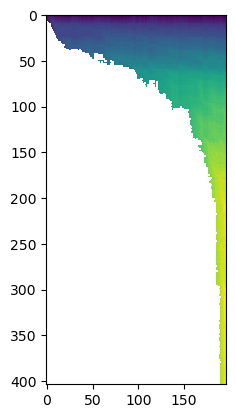

In [52]:
# T = tempreture parameter, go = gap opening pe
T = 1
go = -3.5
ge = -.3
local = False
pre = np.float32
# In our case the S matrix is in the Logspace. so we have to calculate the exponetiate the S matrix. 
S_exp = np.exp(S/T, dtype = pre)
# *_hat describes the results of the backward algorithm inspierd form the muckstein paper. 
#Since the Backward algorithm is the same as the forward just with the fliped input matrix we flip our S matrix here.
S_hat = S_exp[::-1,::-1]

length = 32
# prepare the V and W vector as described.
vj = np.exp(np.arange((length-1)*ge + go ,go-ge, -ge, dtype = pre)/T)
wj = np.exp(np.arange((length-1)*ge , -ge, -ge, dtype = pre)/T)

#calculate the forward and backward path. 
zm, ze, zf, zmax, current_max = forward_backward_block_local(S_exp, vj, wj, T, go, ge, length, pre)
zm_hat, ze_hat, zf_hat, zmax_hat, current_max_hat = forward_backward_block_local(S_hat, vj, wj, T, go, ge, length, pre)

# To calculate the the final probability matrix we have to multiply zm and zm_hat pairwise and normalize it by 
# the sum over zm as described in the muckstein paper
zm, zm_hat = np.log(zm[1:,1:]), np.log(zm_hat[1:,1:])
zm = zm + np.cumsum(zmax[1:]).reshape(-1,1)
zm_hat = zm_hat + np.cumsum(zmax_hat[1:]).reshape(-1,1)


P = np.exp((zm + zm_hat[::-1,::-1]- (S/T) - logsumexp(np.append(zm,1))))

plt.imshow(zm)

### Merging Two Approaches ###

We can merge the concepts of calculating alignments in segments and maintaining a separate maximum for each segment. In this approach, we divide the S matrix into segments and apply a similar methodology as mentioned earlier. Initially, we compute the alignment for an entire segment, utilizing the final row to set up the matrix for the subsequent segment. This method simplifies rescaling in Python, although it might not be the most efficient in terms of memory data retrieval.

For this strategy, we must monitor several aspects. It's necessary to store the maximum value for each row within every segment, and we need to initialize the first column of the $Z^M$, $Z^E$, and $Z^F$ matrices using the last column from the preceding segment. This initial column must be rescaled during the computation of a segment, as we also rescale all other values.

To manage overflows effectively, we should not start with the actual values but with their logarithmic values, converting them back to their exponential form only when needed, ensuring they are already rescaled by then.

In [309]:
def forward_backward_saveBlockMax_local(S, z_init, vj, wj, T, go, ge, pre):
    exp_go = np.exp(go/T)
    exp_ge = np.exp(ge/T)
    
    zm = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    ze = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    zf = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    
    # Initialize the first row of the segment
    zm[1:,0] = z_init[0]
    ze[1:,0] = z_init[1]
    zf[1:,0] = z_init[2]
    
    # in this case ze[i,0] is not 0 so we have to include it to pur vectorization of ze
    exp_ge_arr = np.exp((np.arange(ge, (S.shape[1])* ge + ge,ge,dtype = pre))/T)[:S.shape[1]]
    
    
    
    zmax = np.zeros(S.shape[0]+1)
    current_max = 0
    for i in range(1,S.shape[0]+1):
        #in the first line we dont have to rescale it since all values are zero
        if i != 1:
            # in all other cases we need to calculate the exponent since we initialized with log values   
            zm[i-1,0] , ze[i-1,0],zf[i-1,0] = np.exp(zm[i-1,0]), np.exp(ze[i-1,0]), np.exp(zf[i-1,0])
        
        #calculate zm as alway with the rescaled 1 by current max
        zm[i,1:] = ((zm[i-1,:-1] + ze[i-1,:-1] + zf[i-1,:-1] + (np.exp(-current_max))) *S[i-1,:])
        
        # some test code of ze
        #for j in range(1,S.shape[1]+1):
        #    if j == 1:
        #        ze[i,j] = (np.exp(zm[i,j-1]) * exp_go + np.exp(ze[i,j-1]) * exp_ge)
        #    else:
        #        ze[i,j] = (zm[i,j-1] * exp_go + ze[i,j-1] * exp_ge)
        
        # we need the exponent of zm[i,0] to calculate ze. but doing it we also need the log later on
        zm_exp = np.copy(zm[i,:-1])
        zm_exp[0] = np.exp(zm_exp[0])
        ze[i,1:] = (np.cumsum(zm_exp * vj)/wj)  + np.exp(ze[i,0]) * exp_ge_arr
        zf[i,1:] = (zm[i-1,1:] * exp_go + zf[i-1,1:] * exp_ge)
        
        # save the maximum and rescale it the values as before
        z_temp = np.max([zm[i,1:]])
        zmax[i] = np.log(z_temp)
        current_max += zmax[i]
        #zm[i:,:],ze[i:,:], zf[i:,:] = zm[i:,:]/z_temp ,ze[i:,:]/z_temp, zf[i:,:]/z_temp
        zm[i,1:],ze[i,1:], zf[i,1:] = zm[i,1:]/z_temp ,ze[i,1:]/z_temp, zf[i,1:]/z_temp
        
        # make sure we rescale the log values we initialized befor aswell
        if i != S.shape[0]:
            zm[i+1,0] ,ze[i+1,0], = zm[i+1,0] - current_max ,ze[i+1,0] - current_max
        zm[i,0] ,ze[i,0], = zm[i,0] - zmax[i] ,ze[i,0] - zmax[i]
        zf[i,0]  = zf[i,0]  - current_max
    return zm[1:,1:], ze[1:,1:], zf[1:,1:], zmax, current_max

In [310]:
S = calcS_np(ss1, ss2, aa1, aa2, mat3di, blosum)

/tmp/ipykernel_99062/1889098906.py:21: RuntimeWarning: divide by zero encountered in log
  init = np.log(np.zeros_like(S_exp))
/tmp/ipykernel_99062/1889098906.py:49: RuntimeWarning: divide by zero encountered in log
  np.log(zf[:,end-1]) + rescale]
/tmp/ipykernel_99062/1889098906.py:59: RuntimeWarning: divide by zero encountered in log
  np.log(zf[:,end-1]) + rescale]


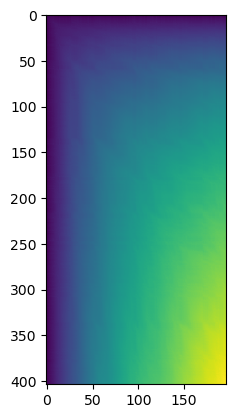

In [311]:
T = 10
go = -3.5
ge = -.3
pre = np.float32
#pre = np.longdouble
S_exp = np.exp(S/T, dtype = pre)
S_hat = S_exp[::-1,::-1]


#calculate the length of blocks we want to process 
#use a divider of S.shape[1] otherwise we have to handle some rest colums 
length = int(S.shape[1]/28)
blocks = int(S.shape[1]/length)

# prepare the V and W vector as described.
vj = np.exp(np.arange((length-1)*ge + go ,go-ge, -ge, dtype = pre)/T)
wj = np.exp(np.arange((length-1)*ge , -ge, -ge, dtype = pre)/T)


# initalize the first block with -inf since we take the exponent to bring it to zero
init = np.log(np.zeros_like(S_exp))
#zm = np.zeros_like(S_exp)
#ze = np.zeros_like(S_exp)
#zf = np.zeros_like(S_exp)
zm = np.copy(init)
ze = np.copy(init)
zf = np.copy(init)
zm_hat = np.copy(init)
ze_hat = np.copy(init)
zf_hat = np.copy(init)

#the maximum is zero for the first block
zmax_all = [np.zeros(S.shape[0])]
zmax_all_hat = [np.zeros(S.shape[0])]

z_init = [zm[:,0], ze[:,0], zf[:,0]]
z_init_hat = [zm_hat[:,0], ze_hat[:,0], zf_hat[:,0]]

# calculate the forward path
for b in range(blocks):
    start, end = b*length, (b+1)*length
    #_, _, _, zmax, current_max = forward_backward_saveBlockMax_local(S_exp[:,start:end], z_init, vj[:length], wj[:length], T, go, ge, pre)

    zm[:,start:end], ze[:,start:end], zf[:,start:end], zmax, current_max = forward_backward_saveBlockMax_local(S_exp[:,start:end], z_init, vj[:length], wj[:length], T, go, ge, pre)
    # rescale and save the maximas for the initialization of the next block
    rescale = np.cumsum(zmax[1:])
    z_init = [np.log(zm[:,end-1]) + rescale, 
              np.log(ze[:,end-1]) + rescale,
              np.log(zf[:,end-1]) + rescale]
    zmax_all.append(zmax)

# the same for the backward path    
for b in range(blocks):
    start, end = b*length, (b+1)*length
    zm_hat[:,start:end], ze[:,start:end], zf[:,start:end], zmax_hat, current_max = forward_backward_saveBlockMax_local(S_hat[:,start:end], z_init_hat, vj[:length], wj[:length], T, go, ge, pre)
    rescale = np.cumsum(zmax_hat[1:])
    z_init_hat = [np.log(zm_hat[:,end-1]) + rescale, 
              np.log(ze[:,end-1]) + rescale,
              np.log(zf[:,end-1]) + rescale]
    zmax_all_hat.append(zmax_hat)
    

    
zm, zm_hat = np.log(zm, dtype = pre), np.log(zm_hat, dtype = pre)
# rescale the values by the maximum in the logspace for each block
for b in range(blocks):
    start, end = b*length, (b+1)*length
    zm[:,start:end] = zm[:,start:end] + np.cumsum(zmax_all[b+1][1:]).reshape(-1,1)
    zm_hat[:,start:end] = zm_hat[:,start:end] + np.cumsum(zmax_all_hat[b+1][1:]).reshape(-1,1)

        

# now we can calculate P. It would be probably good to replace the logsumexp function by aproximating it 
# by the saved maxima, But we did not have the time yet.
P = np.exp((zm + zm_hat[::-1,::-1] - (S/T) - logsumexp(zm)))

plt.imshow(zm)

# Some Memory optimization #


In [313]:
def forward_backward_saveBlockMax_local(S, z_init, vj, wj, T, go, ge, pre):
    exp_go = np.exp(go/T)
    exp_ge = np.exp(ge/T)
    
    zm = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    ze = np.zeros((S.shape[1]+1), dtype = pre)
    zf = np.zeros((S.shape[1]+1), dtype = pre)


    
    # Initialize the first row of the segment
    zm[1:,0] = z_init[0]
    
    ze_start = np.zeros(S.shape[0]+1)
    ze_start[1:] = z_init[1]
    ze_last = np.zeros(S.shape[0]+1)

    zf_start = np.zeros(S.shape[0]+1)
    zf_start[1:] = z_init[2]
    zf_last = np.zeros(S.shape[0]+1)
    
    # in this case ze[i,0] is not 0 so we have to include it to pur vectorization of ze
    exp_ge_arr = np.exp((np.arange(ge, (S.shape[1])* ge + ge,ge,dtype = pre))/T)[:S.shape[1]]
    
    
    
    zmax = np.zeros(S.shape[0]+1)
    current_max = 0
    for i in range(1,S.shape[0]+1):
        #in the first line we dont have to rescale it since all values are zero
        if i != 1:
            # in all other cases we need to calculate the exponent since we initialized with log values   
            zm[i-1,0] , ze[0], zf[0] = np.exp(zm[i-1,0]), np.exp(ze[0]), np.exp(zf_start[i-1])
        
        #calculate zm as alway with the rescaled 1 by current max
        zm[i,1:] = ((zm[i-1,:-1] + ze[:-1] + zf[:-1] + (np.exp(-current_max))) *S[i-1,:])
        
        # some test code of ze
        #for j in range(1,S.shape[1]+1):
        #    if j == 1:
        #        ze[i,j] = (np.exp(zm[i,j-1]) * exp_go + np.exp(ze[i,j-1]) * exp_ge)
        #    else:
        #        ze[i,j] = (zm[i,j-1] * exp_go + ze[i,j-1] * exp_ge)
        
        # we need the exponent of zm[i,0] to calculate ze. but doing it we also need the log later on
        zm_exp = np.copy(zm[i,:-1])
        zm_exp[0] = np.exp(zm_exp[0])
        ze[1:] = (np.cumsum(zm_exp * vj)/wj)  + np.exp(ze_start[i]) * exp_ge_arr
        zf[1:] = (zm[i-1,1:] * exp_go + zf[1:] * exp_ge)
        
        # save the maximum and rescale it the values as before
        z_temp = np.max([zm[i,1:]])
        zmax[i] = np.log(z_temp)
        current_max += zmax[i]
        #zm[i:,:],ze[i:,:], zf[i:,:] = zm[i:,:]/z_temp ,ze[i:,:]/z_temp, zf[i:,:]/z_temp
        zm[i,1:],ze[1:], zf[1:] = zm[i,1:]/z_temp ,ze[1:]/z_temp, zf[1:]/z_temp
        
        # make sure we rescale the log values we initialized befor aswell
        if i != S.shape[0]:
            zm[i+1,0] ,ze_start[i+1], = zm[i+1,0] - current_max ,ze_start[i+1] - current_max
        
        zm[i,0] ,ze[0], = zm[i,0] - zmax[i] ,ze_start[i] - zmax[i]
        #zf[i,0]  = zf[i,0]  - current_max
        zf_start[i] = zf_start[i] - current_max
        ze_last[i] = ze[-1]
        zf_last[i] = zf[-1]
    return zm[1:,1:], ze_last[1:], zf_last[1:], zmax, current_max

/tmp/ipykernel_99062/2720871823.py:21: RuntimeWarning: divide by zero encountered in log
  init = np.log(np.zeros(S_exp.shape[0]))
/tmp/ipykernel_99062/2720871823.py:43: RuntimeWarning: divide by zero encountered in log
  np.log(zf_last) + rescale]
/tmp/ipykernel_99062/2720871823.py:53: RuntimeWarning: divide by zero encountered in log
  np.log(zf_last) + rescale]


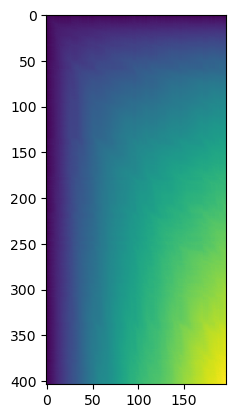

In [316]:
T = 10
go = -3.5
ge = -.3
pre = np.float32
#pre = np.longdouble
S_exp = np.exp(S/T, dtype = pre)
S_hat = S_exp[::-1,::-1]


#calculate the length of blocks we want to process 
#use a divider of S.shape[1] otherwise we have to handle some rest colums 
length = int(S.shape[1]/28)
blocks = int(S.shape[1]/length)

# prepare the V and W vector as described.
vj = np.exp(np.arange((length-1)*ge + go ,go-ge, -ge, dtype = pre)/T)
wj = np.exp(np.arange((length-1)*ge , -ge, -ge, dtype = pre)/T)


# initalize the first block with -inf since we take the exponent to bring it to zero
init = np.log(np.zeros(S_exp.shape[0]))
zm = np.empty_like(S_exp)
zm_hat = np.empty_like(S_exp)


#the maximum is zero for the first block
zmax_all = [np.zeros(S.shape[0])]
zmax_all_hat = [np.zeros(S.shape[0])]

z_init = [np.copy(init), np.copy(init), np.copy(init)]
z_init_hat = [np.copy(init), np.copy(init), np.copy(init)]

# calculate the forward path
for b in range(blocks):
    start, end = b*length, (b+1)*length
    #_, _, _, zmax, current_max = forward_backward_saveBlockMax_local(S_exp[:,start:end], z_init, vj[:length], wj[:length], T, go, ge, pre)

    zm[:,start:end], ze_last, zf_last, zmax, current_max = forward_backward_saveBlockMax_local(S_exp[:,start:end], z_init, vj[:length], wj[:length], T, go, ge, pre)
    # rescale and save the maximas for the initialization of the next block
    rescale = np.cumsum(zmax[1:])
    z_init = [np.log(zm[:,end-1]) + rescale, 
              np.log(ze_last) + rescale,
              np.log(zf_last) + rescale]
    zmax_all.append(zmax)

# the same for the backward path    
for b in range(blocks):
    start, end = b*length, (b+1)*length
    zm_hat[:,start:end], ze_last, zf_last, zmax_hat, current_max = forward_backward_saveBlockMax_local(S_hat[:,start:end], z_init_hat, vj[:length], wj[:length], T, go, ge, pre)
    rescale = np.cumsum(zmax_hat[1:])
    z_init_hat = [np.log(zm_hat[:,end-1]) + rescale, 
              np.log(ze_last) + rescale,
              np.log(zf_last) + rescale]
    zmax_all_hat.append(zmax_hat)
    

    
zm, zm_hat = np.log(zm, dtype = pre), np.log(zm_hat, dtype = pre)
# rescale the values by the maximum in the logspace for each block
for b in range(blocks):
    start, end = b*length, (b+1)*length
    zm[:,start:end] = zm[:,start:end] + np.cumsum(zmax_all[b+1][1:]).reshape(-1,1)
    zm_hat[:,start:end] = zm_hat[:,start:end] + np.cumsum(zmax_all_hat[b+1][1:]).reshape(-1,1)

        

# now we can calculate P. It would be probably good to replace the logsumexp function by aproximating it 
# by the saved maxima, But we did not have the time yet.
P = np.exp((zm + zm_hat[::-1,::-1] - (S/T) - logsumexp(zm)))

plt.imshow(zm.astype(np.float32))

## Playground ##

In [317]:
#0.6840431219079673731
P.max()

0.6840128719004649

In [15]:
def forward_backward_maxblock_local(S, vj, wj, T, go, ge, length, pre):
    exp_go = np.exp(go/T)
    exp_ge = np.exp(ge/T)
    zm = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    ze = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    zf = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    
    
    blocks = int(S.shape[1]/length)
    start, end = 0,0
    rest = S.shape[1] - (blocks*length)
    exp_ge_arr = np.exp((np.arange(ge, length* ge + ge,ge,dtype = pre))/T)
    
    zmax = np.zeros((S.shape[0]+1, blocks))
    current_max = np.zeros(blocks+1)
    
    for b in range(blocks):
        start, end = b*length, (b+1) * length 
        scale = np.exp(((np.cumsum(zmax[:,0]))), dtype = pre)

        for i in range(1,S.shape[0]+1):
            zm[i-1,start] = (zm[i-1,start]*scale[i-1])/np.exp(current_max[b], dtype = pre) 
            ze[i-1,start] = (ze[i-1,start]*scale[i-1])/np.exp(current_max[b], dtype = pre) 
            zf[i-1,start] = (zf[i-1,start]*scale[i-1])/np.exp(current_max[b], dtype = pre) 
            
            zm[i,start+1:end+1] = ((zm[i-1,start:end] + ze[i-1,start:end] + zf[i-1,start:end] + np.exp(-current_max[b], dtype = pre)) *S[i-1,start:end])
            ze[i, start+1: end+1] = (np.cumsum(zm[i,start: end] * vj)/wj) #+ ze[i,start] * exp_ge_arr
            zf[i,start+1:end+1] = (zm[i-1,start+1:end+1] * exp_go + zf[i-1,start+1:end+1] * exp_ge)
            
            zm[i-1,start] = (zm[i-1,start]/scale[i-1])*np.exp(current_max[b], dtype = pre) 
            ze[i-1,start] = (ze[i-1,start]/scale[i-1])*np.exp(current_max[b], dtype = pre) 
            zf[i-1,start] = (zf[i-1,start]/scale[i-1])*np.exp(current_max[b], dtype = pre) 

            
            z_temp = np.max([zm[i,start+1:end+1], ze[i,start+1:end+1], zf[i,start+1:end+1]])
            zmax[i,b] = np.log(z_temp)
            current_max[b] += zmax[i,b]         
            zm[i,start+1:end+1], ze[i,start+1:end+1], zf[i,start+1:end+1] = zm[i,start+1:end+1]/z_temp ,ze[i,start+1:end+1]/z_temp, zf[i,start+1:end+1]/z_temp
        

    return zm, ze, zf, zmax, current_max

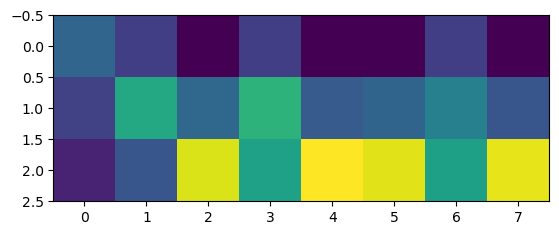

In [16]:
T = 1
go = -3.5
ge = -.3
local = False
pre = np.float64
pre = np.longdouble
S_exp = np.exp(S/T, dtype = pre)[:3,:8]
S_hat = S_exp[::-1,::-1]
length = int(S_exp.shape[1]/1)
blocks = int(S_exp.shape[1]/length)


vj = np.exp(np.arange((length-1)*ge + go ,go-ge-0.1, -ge, dtype = pre)/T)
wj = np.exp(np.arange((length-1)*ge , -ge, -ge, dtype = pre)/T)
rest = S_exp.shape[1] - (blocks*length)
#calculate the forward and backward path. 
zm, ze, zf, zmax, current_max = forward_backward_maxblock_local(S_exp, vj, wj, T, go, ge, length, pre)
zm_hat, ze_hat, zf_hat, zmax_hat, current_max_hat = forward_backward_maxblock_local(S_hat, vj, wj, T, go, ge, length, pre)

start, end = 0,0
zm, zm_hat = np.log(zm[1:,1:]), np.log(zm_hat[1:,1:])
for b in range(int(S_exp.shape[1]/length)):
    start, end = b*length, (b+1) * length
    zm[:,start:end] = zm[:,start:end] + np.cumsum(zmax[1:,b]).reshape(-1,1)
    zm_hat[:,start:end] = zm_hat[:,start:end] + np.cumsum(zmax_hat[1:,0]).reshape(-1,1)

#if rest != 0:
#    zm[:,end:] = zm[:, end:] + np.cumsum(zmax[1:,-1]).reshape(-1,1)
#    zm_hat[:, end:] = zm_hat[:, end:] + np.cumsum(zmax_hat[1:,-1]).reshape(-1,1)

P = np.exp(zm + zm_hat[::-1,::-1]- (S[:3,:8]/T) - logsumexp(np.append(zm,1)))

plt.imshow(zm[:,:])

In [200]:

def forward_backward_saveMaxBlock_local2(S, vj, wj, T, go, ge, length, pre):
    exp_go = np.exp(go/T)
    exp_ge = np.exp(ge/T)
    zm = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype=pre)
    ze = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype=pre)
    zf = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype=pre)
    
    current_max = 0
    blocks = int(S.shape[1]/length)
    start, end = 0, 0
    exp_ge_arr = np.exp(np.arange((length-1)*ge, -ge, -ge, dtype=pre)/T)
    zmax = np.zeros((S.shape[0]+1, blocks), dtype = pre)
    zm[0,:] = 1
    
    for i in range(1, S.shape[0]+1):
        zm_temp = np.copy(zm[i-1, :-1])
        zm_temp[start] = zm_temp[start] * np.exp(zmax[i-1,0] - zmax[i-1,1])
        ze_temp = np.copy(ze[i-1, :-1])
        ze_temp[start] = ze_temp[start] * np.exp(zmax[i-1,0] - zmax[i-1,1])
        zf_temp = np.copy(zf[i-1, :-1])
        zf_temp[start] = zf_temp[start] * np.exp(zmax[i-1,0] - zmax[i-1,1])
        
        
        zm[i,1:] = ((zm_temp + ze_temp + zf_temp) * S[i-1, :])
        ze[i, 1:] = (np.cumsum((zm[i,:-1]) * vj)/wj)
        zf[i, 1:] = (zm[i-1, 1:] * exp_go + zf[i-1, 1:] * exp_ge)
        #for b in range(blocks):
        #    start, end = b*length, (b+1) * length
            #ze[i, start+1: end+1] = (np.cumsum(zm[i,start: end] * vj)/wj) + ze[i,start] * exp_ge_arr
        #    for j in range(start,end):
        #        ze[i,j+1] = (zm[i,j] * exp_go + ze[i,j] * exp_ge)
               # else:
                #    ze[i,j+1] = (zm[i,j] * exp_go + ze[i,j] * exp_ge)
         #+ (ze[i, start]) * exp_ge_arr
            #zf[i, start+1:end+1] = (zm[i-1, start+1:end+1] * exp_go + zf[i-1, start+1:end+1] * exp_ge)

        block_max = np.max(zm[i,:])
        #zmax[i,:] = np.log(block_max)
        current_max += np.log(block_max)
        #zm[i,:],ze[i,:], zf[i,:] = zm[i,:]/block_max ,ze[i,:]/block_max, zf[i,:]/block_max
        
        for b in range(blocks):
            start, end = b*length, (b+1) * length
            block_max = np.max(zm[i,start+1:end+1])
            #current_max += np.log(block_max)
            zmax[i,b] = np.log(block_max)            
            zm[i, start+1:end+1] /= block_max
            ze[i, start+1:end+1] /= block_max
            zf[i, start+1:end+1] /= block_max

    for b in range(0):
        start, end = b*length, (b+1) * length
        block_max = np.max(zm[-1, start+1:end+1])
        current_max += np.log(block_max)
        zmax[-1,b] = np.log(block_max)
        
        start, end = b*length, (b+1) * length
        zm[-1, start+1:end+1] /= np.max(zm[-1, start+1:end+1])
        ze[-1, start+1:end+1] /= np.max(zm[-1, start+1:end+1])
        zf[-1, start+1:end+1] /= np.max(zm[-1, start+1:end+1])
    return zm[1:, 1:], ze[1:, 1:], zf[1:, 1:], zmax, current_max

In [201]:
S = calcS_np(ss1, ss2, aa1, aa2, mat3di, blosum)#[:3,:4]

/tmp/ipykernel_3283/294744090.py:43: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(zm[:,:]))


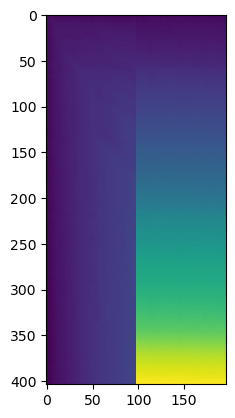

In [204]:
T = 1
go = -3.5
ge = -.3
local = True
pre = np.float64
pre = np.longdouble
S_exp = np.exp(S/T, dtype = pre)
S_hat = S_exp[::-1,::-1]

length = int(S.shape[1]/2)
blocks = int(S.shape[1]/length)

zmax = np.ones(S.shape[0]+1)
zmax_hat = np.zeros(S.shape[0]+1)


vj = np.exp(np.arange((S.shape[1]-1)*ge + go ,go-ge, -ge, dtype = pre)/T)
#vj = np.exp(np.arange((length-1)*ge + go ,go, -ge, dtype = pre)/T)

wj = np.exp(np.arange((S.shape[1]-1)*ge , -ge, -ge, dtype = pre)/T)

#zm, ze, zf = np.zeros_like(S, dtype = pre), np.zeros_like(S, dtype = pre), np.zeros_like(S, dtype = pre)
#zm_hat, ze_hat, zf_hat = np.zeros_like(S, dtype = pre), np.ones_like(S, dtype = pre), np.ones_like(S, dtype = pre)

zm, ze, zf, zmax, current_max = forward_backward_saveMaxBlock_local2(S_exp, vj, wj, T, go, ge, length, pre)

zm_hat, ze_hat, zf_hat, zmax_hat, current_max = forward_backward_saveMaxBlock_local2(S_hat, vj, wj, T, go, ge, length, pre)
   
#zm, zm_hat = np.log(zm), np.log(zm_hat)

#zm += np.cumsum(zmax[1:]).reshape(-1,1)

for b in range(blocks):
    start, end = b*length, (b+1)*length
    #zm[:,start:end] += np.cumsum(zmax[1:,b]).reshape(-1,1)
    zm[:,start:end] *= np.exp(np.cumsum(zmax[1:,b])).reshape(-1,1)
    ze[:,start:end] *= np.exp(np.cumsum(zmax[1:,b])).reshape(-1,1)
    zf[:,start:end] *= np.exp(np.cumsum(zmax[1:,b])).reshape(-1,1)
    #zm_hat[:,start:end] = zm_hat[:,start:end] + zmax_hat[1:,b].reshape(-1,1)

#P = np.exp((zm + zm_hat[::-1,::-1] - (S/T) - zm[-1,-1]))

plt.imshow(np.log(zm[:,:]))

In [193]:
zm

array([[1.09663316e+03, 2.01375271e+00, 4.52827183e-04, 2.01375271e+00],
       [2.92238481e+00, 2.49695184e+08, 1.79709203e+03, 1.78611509e+09],
       [9.02621629e-06, 7.23081271e+01, 2.22796888e+12, 1.44189639e+05]],
      dtype=float128)

In [189]:
np.array([[1.09663316e+03, 2.01375271e+00, 4.52827183e-04, 2.01375271e+00],
       [2.92238481e+00, 2.49695184e+08, 1.84815206e+03, 1.85860095e+09],
       [3.51609214e-02, 7.43140480e+01, 1.21328927e+15, 6.95180289e+07]])

array([[1.09663316e+03, 2.01375271e+00, 4.52827183e-04, 2.01375271e+00],
       [2.92238481e+00, 2.49695184e+08, 1.84815206e+03, 1.85860095e+09],
       [3.51609214e-02, 7.43140480e+01, 1.21328927e+15, 6.95180289e+07]])

In [64]:
ze

array([[0.00000000e+00, 3.31154520e+01, 2.45933403e+01, 1.82192082e+01],
       [0.00000000e+00, 8.82483747e-02, 1.38459974e+04, 1.03116347e+04],
       [0.00000000e+00, 2.72568114e-07, 1.56190905e+01, 6.72788306e+10]],
      dtype=float128)

In [862]:
np.array([[0.00000000e+00, 3.31154520e+01, 2.45933403e+01, 1.82192082e+01],
       [0.00000000e+00, 8.82483747e-02, 7.54014126e+06, 5.58592984e+06],
       [0.00000000e+00, 1.06176783e-03, 2.24487638e+00, 3.66381613e+13]],)

array([[0.00000000e+00, 3.31154520e+01, 2.45933403e+01, 1.82192082e+01],
       [0.00000000e+00, 8.82483747e-02, 7.54014126e+06, 5.58592984e+06],
       [0.00000000e+00, 1.06176783e-03, 2.24487638e+00, 3.66381613e+13]])

In [863]:
zf

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.31154520e+01, 6.08100626e-02, 1.36741961e-05, 6.08100626e-02],
       [2.46207786e+01, 7.54014124e+06, 1.02493118e-01, 5.39360024e+07]],
      dtype=float128)

In [864]:
np.array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.31154520e+01, 6.08100626e-02, 1.36741961e-05, 6.08100626e-02],
       [2.46207786e+01, 7.54014124e+06, 5.58093665e+01, 5.61248856e+07]])

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.31154520e+01, 6.08100626e-02, 1.36741961e-05, 6.08100626e-02],
       [2.46207786e+01, 7.54014124e+06, 5.58093665e+01, 5.61248856e+07]])

In [851]:
np.exp(go)

0.0301973834223185

In [808]:
S_exp

array([[1.09663316e+03, 2.01375271e+00, 4.52827183e-04, 2.01375271e+00],
       [2.92238481e+00, 2.27485095e+05, 5.11539647e+01, 7.26192067e+07],
       [3.51609214e-02, 2.00643597e+00, 4.85908157e+06, 9.21746450e+00]],
      dtype=float128)

In [814]:
(18.219208272133923)*np.exp(ge)+ (2.01375271e+00*np.exp(go)) 

13.55793151709349

In [866]:
S_exp[0,2:]/S_exp[0,3]

array([2.24867324e-04, 1.00000000e+00], dtype=float128)

In [13]:
1.82192082e+01/2.01375271e+00

9.047391027471294

In [14]:
(1+np.exp(-1.09e3))

1.0

In [32]:
12.21 * 7.26192067e+07

886680513.807